# pygrib

本节介绍如何使用 pygrib 加载 GRIB2 要素场，并使用 cedarkit-maps 绘图。

## 安装 

使用 conda 安装 pygrib

```bash
conda install -c conda-forge pygrib
```

## 准备

导入需要的包

In [1]:
import xarray as xr
import pandas as pd
import pygrib

设置绘图的数据参数，使用 CMA-MESO 2024 年 11 月 14 日 00 时次 024 时效数据。

In [2]:
system_name = "CMA-MESO"
data_type = "cma_meso_3km/grib2/orig"
start_time = pd.to_datetime("2024-11-14 00:00:00")
forecast_time = pd.to_timedelta("24h")

## 加载数据

设置 GRIB2 数据文件路径

In [ ]:
file_path = '/g3/COMMONDATA/OPER/CEMC/MESO_3KM/Prod-grib/2024111400/ORIG/rmf.hgra.2024111400024.grb2'
file_path

'/g3/COMMONDATA/OPER/CEMC/MESO_3KM/Prod-grib/2024111400/ORIG/rmf.hgra.2024111400024.grb2'

> 注：可以使用 reki 库查找本地文件路径

In [4]:
from reki.data_finder import find_local_file

file_path_use_reki = find_local_file(
    data_type,
    start_time=start_time,
    forecast_time=forecast_time,
)
file_path_use_reki

PosixPath('/g3/COMMONDATA/OPER/CEMC/MESO_3KM/Prod-grib/2024111400/ORIG/rmf.hgra.2024111400024.grb2')

使用 pygrib 加载 2 米温度要素场。

In [5]:
grbs = pygrib.open(file_path)
selected_grbs = grbs.select(shortName="2t")
selected_grb = selected_grbs[0]
selected_grb

10:2 metre temperature:K (instant):regular_ll:heightAboveGround:level 2 m:fcst time 24 hrs:from 202411140000

获取经纬度坐标

In [6]:
lats, lons = selected_grb.latlons()
lats[:, 0], lons[0, :]

(array([60.099998, 60.069998, 60.039998, ..., 10.059998, 10.029998,
        10.      ]),
 array([ 70.  ,  70.03,  70.06, ..., 144.94, 144.97, 145.  ]))

获取要素场二维数组

In [7]:
values = selected_grb.values
values.shape

(1671, 2501)

将要素场包装为 `xarray.DataArray` 对象

In [8]:
t_2m_field = xr.DataArray(
    values,
    coords={
        "latitude": lats[:, 0],
        "longitude": lons[0, :],
    },
    dims=["latitude", "longitude"]
) - 273.15
t_2m_field

<xarray.DataArray (latitude: 1671, longitude: 2501)> Size: 33MB
array([[-19.79798437, -19.87098437, -19.94298437, ..., -20.50598437,
        -19.98698437, -19.95998437],
       [ -6.62598437,  -6.78098437,  -6.38398437, ..., -21.55898437,
        -21.51698437, -20.27398437],
       [ -6.43498437,  -6.69698437,  -5.93298437, ..., -21.05498437,
        -21.48098437, -20.02598437],
       ...,
       [ 27.06201563,  27.07301563,  27.06801563, ...,  27.54301563,
         27.55001563,  27.65901563],
       [ 27.09601563,  27.05101563,  27.06801563, ...,  27.57601563,
         27.57201563,  27.66101563],
       [ 27.04401563,  27.05801563,  27.05101563, ...,  27.54901563,
         27.57201563,  27.66101563]])
Coordinates:
  * latitude   (latitude) float64 13kB 60.1 60.07 60.04 ... 10.06 10.03 10.0
  * longitude  (longitude) float64 20kB 70.0 70.03 70.06 ... 144.9 145.0 145.0

## 绘图

使用 cedarkit-maps 绘制 2 米温度填充图

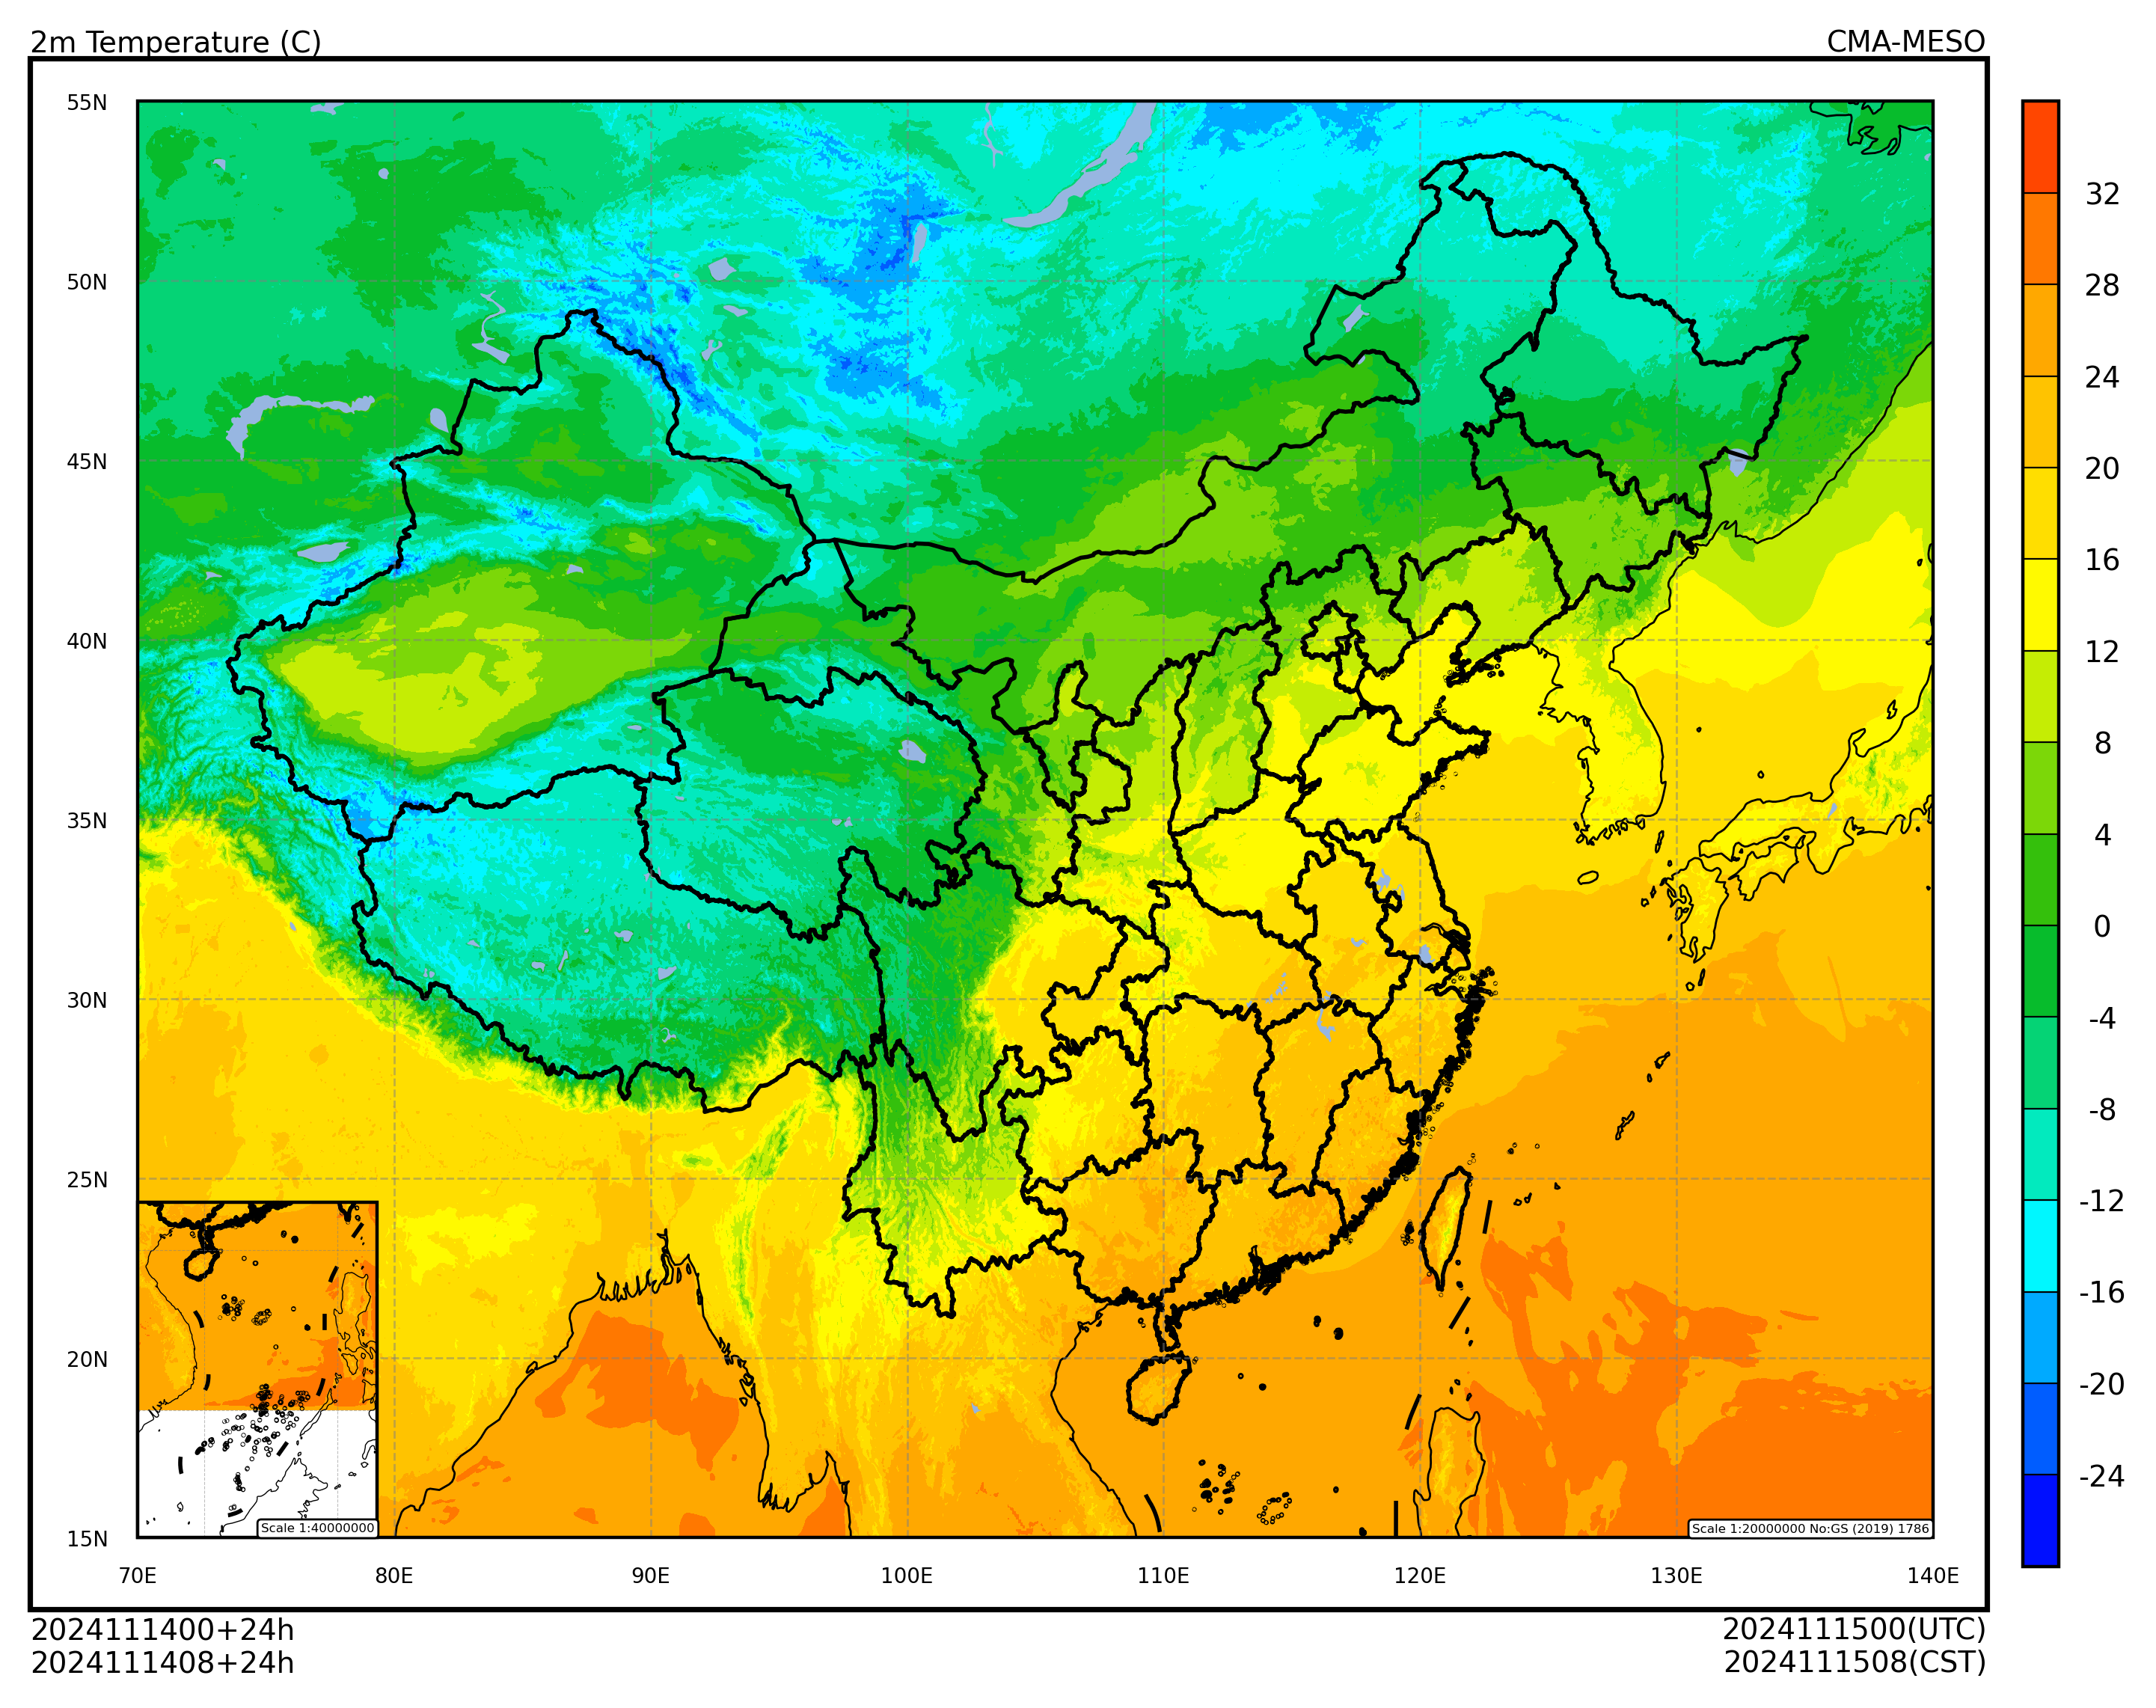

In [9]:
from cedarkit.maps.style import ContourStyle
from cedarkit.maps.chart import Panel
from cedarkit.maps.domains import EastAsiaMapTemplate
from cedarkit.maps.colormap import get_ncl_colormap

t_2m_level = [-24, -20, -16, -12, -8, -4, 0, 4, 8, 12, 16, 20, 24, 28, 32]
color_index = [2, 12, 22, 32, 42, 52, 62, 72, 82, 92, 102, 112, 122, 132, 142, 152]
t_2m_color_map = get_ncl_colormap("BlAqGrYeOrReVi200", index=color_index)
t_2m_style = ContourStyle(
    colors=t_2m_color_map,
    levels=t_2m_level,
    fill=True,
)
domain = EastAsiaMapTemplate()
panel = Panel(domain=domain)
panel.plot(t_2m_field, style=t_2m_style)
domain.set_title(
    panel=panel,
    graph_name="2m Temperature (C)",
    system_name=system_name,
    start_time=start_time,
    forecast_time=forecast_time,
)
domain.add_colorbar(panel=panel, style=t_2m_style)
panel.show()